In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import math
import random

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv1D, Conv2D, Flatten, MaxPooling1D, MaxPooling2D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm

In [2]:
from sklearn.neighbors import KernelDensity # paquete necesario
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate

In [3]:
from tensorflow.keras.models import Model

In [4]:
!pip install xgboost

import xgboost
from xgboost import XGBRegressor, XGBClassifier

You should consider upgrading via the '/home/andres/anaconda3/bin/python -m pip install --upgrade pip' command.


In [5]:
import h5py

import glob
import numpy as np
import os.path as path
import imageio
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime
import keras
from keras import regularizers
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, precision_recall_curve, auc,recall_score
#from keras.optimizers import Adam
from keras.regularizers import l2
import h5py
from sklearn.model_selection import GridSearchCV
from keras.backend import cast, greater, clip, floatx,epsilon
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from sklearn.model_selection import StratifiedKFold

### Load Data

In [6]:
filefolder = '../../data2024/processed/'

###################
# BACKGROUND FILE #
###################

filename_B = 'ER/ER_all.hdf5'


###############
# SIGNAL FILE #
###############

# select the DM mass
mDM = 500

filename_S = 'mDM' + str(mDM) + 'GeV/WP_mDM' + str(mDM) + 'GeV_sig1045.hdf5'

##### Load the h5

In [7]:
# OPEN THE SAVED FILE TO CHECK IT
f_B = h5py.File(filefolder+filename_B,'r')
f_S = h5py.File(filefolder+filename_S,'r')

# show the groups
print( f_B.keys() )

# should be more than 10k events in each group
print('\n Background Events: ')
for groups1 in f_B.keys():
    print(len(f_B[groups1].keys()))

print('\n Signal Events')
for groups1 in f_S.keys():
    print(len(f_S[groups1].keys()))

<KeysViewHDF5 ['HITS_bot', 'HITS_bot_img', 'HITS_top', 'HITS_top_img', 'peakS1_onlyhits', 'peakS1_raw', 'peakS2_onlyhits', 'peakS2_raw']>

 Background Events: 
35549
35549
35549
35549
35549
35549
35549
35549

 Signal Events
32015
32015
32015
32015
32015
32015
32015
32015


In [8]:
################
# ALL THE DATA #
################


# to normalize
scaler = preprocessing.MinMaxScaler()

# Number of data points (per-class) for the ML classifier
#num_data = 30000
num_data = 15000


In [9]:
###################
# peakS1_onlyhits #
###################

# First:
# The max len for the time series

max_pS1_B = 0
max_pS1_S = 0

for i in range(1, num_data+1):
    max_pS1_B = max(max_pS1_B, len( f_B['peakS1_onlyhits/ev_'+str(i)] ))
    max_pS1_S = max(max_pS1_S, len( f_S['peakS1_onlyhits/ev_'+str(i)] ))
    
    
max_pS1_both = max(max_pS1_B,max_pS1_S)

print('max_pS1_both lenght: ', max_pS1_both)



# Second:
# add the events in a matrix, but all with the same length -> fill with zeros

# how many elements do we need to make all the peak (S1 or S2) arrays with the same length
diff_elem_S1_B = max_pS1_both - len( f_B['peakS1_onlyhits/ev_1'][()] )
diff_elem_S1_S = max_pS1_both - len( f_S['peakS1_onlyhits/ev_1'][()] )

# add zeros at the end
peakS1_onlyhits_B = np.pad(f_B['peakS1_onlyhits/ev_1'][()], (0, diff_elem_S1_B), 'constant')
peakS1_onlyhits_S = np.pad(f_S['peakS1_onlyhits/ev_1'][()], (0, diff_elem_S1_S), 'constant')

for i in range(2, num_data+1):
    
    # how many elements do we need to make all the peak (S1 or S2) arrays with the same length
    diff_elem_S1_B = max_pS1_both - len( f_B['peakS1_onlyhits/ev_'+str(i)][()] )
    diff_elem_S1_S = max_pS1_both - len( f_S['peakS1_onlyhits/ev_'+str(i)][()] )
    
    # add zeros at the end
    aux_S1_B = np.pad(f_B['peakS1_onlyhits/ev_'+str(i)][()], (0, diff_elem_S1_B), 'constant')
    aux_S1_S = np.pad(f_S['peakS1_onlyhits/ev_'+str(i)][()], (0, diff_elem_S1_S), 'constant')
    
    # add new event to the matrix as a row
    peakS1_onlyhits_B = np.row_stack([peakS1_onlyhits_B,aux_S1_B])
    peakS1_onlyhits_S = np.row_stack([peakS1_onlyhits_S,aux_S1_S])
    
    
    

# X and Y for the classifier
X_peakS1 = np.row_stack([peakS1_onlyhits_B,peakS1_onlyhits_S])
# normalize
X_peakS1 = scaler.fit_transform(X_peakS1)

del peakS1_onlyhits_B
del peakS1_onlyhits_S






###################
# CONCATENATE ALL #
###################

X_mon1 = np.concatenate([X_peakS1],axis=1)

del X_peakS1

# labels
y_mon1 = np.concatenate([np.zeros(num_data),np.ones(num_data)])


# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon1_aux, X_mon1_test, y_mon1_aux, y_mon1_test = train_test_split(X_mon1,
                                                                y_mon1,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon1,
                                                                shuffle=True)

del X_mon1
del y_mon1

X_mon1_train, X_mon1_val, y_mon1_train, y_mon1_val = train_test_split(X_mon1_aux,
                                                                  y_mon1_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon1_aux,
                                                                  shuffle=True)

del X_mon1_aux
del y_mon1_aux

print('')
print('X_mon1_train : ', X_mon1_train.shape)
print('y_mon1_train : ', y_mon1_train.shape)
print('X_mon1_val : ', X_mon1_val.shape)
print('y_mon1_val : ', y_mon1_val.shape)
print('X_mon1_test : ', X_mon1_test.shape)
print('y_mon1_test : ', y_mon1_test.shape)
print('')

max_pS1_both lenght:  197

X_mon1_train :  (15000, 197)
y_mon1_train :  (15000,)
X_mon1_val :  (5000, 197)
y_mon1_val :  (5000,)
X_mon1_test :  (10000, 197)
y_mon1_test :  (10000,)



In [10]:
###################
# peakS2_onlyhits #
###################

# First:
# The max len for the time series

max_pS2_B = 0
max_pS2_S = 0

for i in range(1, num_data+1):
    max_pS2_B = max(max_pS2_B, len( f_B['peakS2_onlyhits/ev_'+str(i)] ))
    max_pS2_S = max(max_pS2_S, len( f_S['peakS2_onlyhits/ev_'+str(i)] ))
    
    
max_pS2_both = max(max_pS2_B,max_pS2_S)

print('max_pS2_both lenght: ', max_pS2_both)



# Second:
# add the events in a matrix, but all with the same length -> fill with zeros

# how many elements do we need to make all the peak (S2 or S2) arrays with the same length
diff_elem_S2_B = max_pS2_both - len( f_B['peakS2_onlyhits/ev_1'][()] )
diff_elem_S2_S = max_pS2_both - len( f_S['peakS2_onlyhits/ev_1'][()] )

# add zeros at the end
peakS2_onlyhits_B = np.pad(f_B['peakS2_onlyhits/ev_1'][()], (0, diff_elem_S2_B), 'constant')
peakS2_onlyhits_S = np.pad(f_S['peakS2_onlyhits/ev_1'][()], (0, diff_elem_S2_S), 'constant')

for i in range(2, num_data+1):
    
    # how many elements do we need to make all the peak (S2 or S2) arrays with the same length
    diff_elem_S2_B = max_pS2_both - len( f_B['peakS2_onlyhits/ev_'+str(i)][()] )
    diff_elem_S2_S = max_pS2_both - len( f_S['peakS2_onlyhits/ev_'+str(i)][()] )
    
    # add zeros at the end
    aux_S2_B = np.pad(f_B['peakS2_onlyhits/ev_'+str(i)][()], (0, diff_elem_S2_B), 'constant')
    aux_S2_S = np.pad(f_S['peakS2_onlyhits/ev_'+str(i)][()], (0, diff_elem_S2_S), 'constant')
    
    # add new event to the matrix as a row
    peakS2_onlyhits_B = np.row_stack([peakS2_onlyhits_B,aux_S2_B])
    peakS2_onlyhits_S = np.row_stack([peakS2_onlyhits_S,aux_S2_S])
    
    
    

# X and Y for the classifier
X_peakS2 = np.row_stack([peakS2_onlyhits_B,peakS2_onlyhits_S])
# normalize
X_peakS2 = scaler.fit_transform(X_peakS2)

del peakS2_onlyhits_B
del peakS2_onlyhits_S









###################
# CONCATENATE ALL #
###################

X_mon2 = np.concatenate([X_peakS2],axis=1)

del X_peakS2

# labels
y_mon2 = np.concatenate([np.zeros(num_data),np.ones(num_data)])


# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon2_aux, X_mon2_test, y_mon2_aux, y_mon2_test = train_test_split(X_mon2,
                                                                y_mon2,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon2,
                                                                shuffle=True)

del X_mon2
del y_mon2

X_mon2_train, X_mon2_val, y_mon2_train, y_mon2_val = train_test_split(X_mon2_aux,
                                                                  y_mon2_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon2_aux,
                                                                  shuffle=True)

del X_mon2_aux
del y_mon2_aux

print('')
print('X_mon2_train : ', X_mon2_train.shape)
print('y_mon2_train : ', y_mon2_train.shape)
print('X_mon2_val : ', X_mon2_val.shape)
print('y_mon2_val : ', y_mon2_val.shape)
print('X_mon2_test : ', X_mon2_test.shape)
print('y_mon2_test : ', y_mon2_test.shape)
print('')

max_pS2_both lenght:  2298

X_mon2_train :  (15000, 2298)
y_mon2_train :  (15000,)
X_mon2_val :  (5000, 2298)
y_mon2_val :  (5000,)
X_mon2_test :  (10000, 2298)
y_mon2_test :  (10000,)



In [11]:
######################
# ONLY HITS_bot DATA #
######################


hits_bot_B = np.array( f_B['HITS_bot/ev_1'] )
hits_bot_S = np.array( f_S['HITS_bot/ev_1'] )


for i in range(2,num_data+1):
    # add new event to the matrix as a row
    hits_bot_B = np.row_stack([hits_bot_B,np.array( f_B['HITS_bot/ev_'+str(i)] )])
    hits_bot_S = np.row_stack([hits_bot_S,np.array( f_S['HITS_bot/ev_'+str(i)] )])
    
    



# X and Y for the classifier
X_mon3 = np.row_stack([hits_bot_B,hits_bot_S])
# normalize
X_mon3 = scaler.fit_transform(X_mon3)
#X_mon3 = np.reshape(X_mon3, (2*num_data,128,128,1))

del hits_bot_B
del hits_bot_S

# labels
y_mon3 = np.concatenate([np.zeros(num_data),np.ones(num_data)])



# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon3_aux, X_mon3_test, y_mon3_aux, y_mon3_test = train_test_split(X_mon3,
                                                                y_mon3,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon3,
                                                                shuffle=True)

del X_mon3
del y_mon3

X_mon3_train, X_mon3_val, y_mon3_train, y_mon3_val = train_test_split(X_mon3_aux,
                                                                  y_mon3_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon3_aux,
                                                                  shuffle=True)

del X_mon3_aux
del y_mon3_aux

print('')
print('X_mon3_train : ', X_mon3_train.shape)
print('y_mon3_train : ', y_mon3_train.shape)
print('X_mon3_val : ', X_mon3_val.shape)
print('y_mon3_val : ', y_mon3_val.shape)
print('X_mon3_test : ', X_mon3_test.shape)
print('y_mon3_test : ', y_mon3_test.shape)
print('')


X_mon3_train :  (15000, 121)
y_mon3_train :  (15000,)
X_mon3_val :  (5000, 121)
y_mon3_val :  (5000,)
X_mon3_test :  (10000, 121)
y_mon3_test :  (10000,)



In [12]:
######################
# ONLY HITS_top DATA #
######################


hits_top_B = np.array( f_B['HITS_top/ev_1'] )
hits_top_S = np.array( f_S['HITS_top/ev_1'] )


for i in range(2,num_data+1):
    # add new event to the matrix as a row
    hits_top_B = np.row_stack([hits_top_B,np.array( f_B['HITS_top/ev_'+str(i)] )])
    hits_top_S = np.row_stack([hits_top_S,np.array( f_S['HITS_top/ev_'+str(i)] )])
    
    



# X and Y for the classifier
X_mon4 = np.row_stack([hits_top_B,hits_top_S])
# normalize
X_mon4 = scaler.fit_transform(X_mon4)
#X_mon4 = np.reshape(X_mon4, (2*num_data,128,128,1))

del hits_top_B
del hits_top_S

# labels
y_mon4 = np.concatenate([np.zeros(num_data),np.ones(num_data)])



# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon4_aux, X_mon4_test, y_mon4_aux, y_mon4_test = train_test_split(X_mon4,
                                                                y_mon4,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon4,
                                                                shuffle=True)

del X_mon4
del y_mon4

X_mon4_train, X_mon4_val, y_mon4_train, y_mon4_val = train_test_split(X_mon4_aux,
                                                                  y_mon4_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon4_aux,
                                                                  shuffle=True)

del X_mon4_aux
del y_mon4_aux

print('')
print('X_mon4_train : ', X_mon4_train.shape)
print('y_mon4_train : ', y_mon4_train.shape)
print('X_mon4_val : ', X_mon4_val.shape)
print('y_mon4_val : ', y_mon4_val.shape)
print('X_mon4_test : ', X_mon4_test.shape)
print('y_mon4_test : ', y_mon4_test.shape)
print('')


X_mon4_train :  (15000, 127)
y_mon4_train :  (15000,)
X_mon4_val :  (5000, 127)
y_mon4_val :  (5000,)
X_mon4_test :  (10000, 127)
y_mon4_test :  (10000,)



In [13]:
# close the h5 files
f_B.close()
f_S.close()

##### Load the compressed features

B_pbot.shape:  (35549,)
B_ptop.shape:  (35549,)
B_ppeakS1.shape : (35549, 8)
B_ppeakS2.shape:  (35549, 8)
S_pbot.shape:  (32015,)
S_ptop.shape:  (32015,)
S_ppeakS1.shape : (32015, 8)
S_ppeakS2.shape:  (32015, 8)


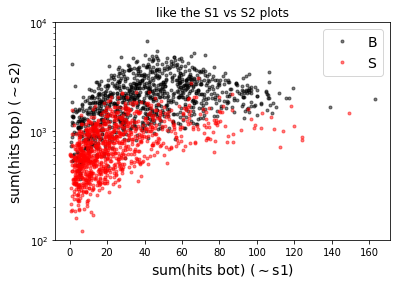

In [14]:
B_pbot = np.loadtxt(filefolder + 'ER/pbot.txt')
B_ptop = np.loadtxt(filefolder + 'ER/ptop.txt')
B_ppeakS1 = np.loadtxt(filefolder + 'ER/ppeakS1.txt')
B_ppeakS2 = np.loadtxt(filefolder + 'ER/ppeakS2.txt')

print('B_pbot.shape: ', B_pbot.shape)
print('B_ptop.shape: ', B_ptop.shape)
print('B_ppeakS1.shape :', B_ppeakS1.shape)
print('B_ppeakS2.shape: ', B_ppeakS2.shape)



S_pbot = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/pbot.txt')
S_ptop = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/ptop.txt')
S_ppeakS1 = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/ppeakS1.txt')
S_ppeakS2 = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/ppeakS2.txt')

print('S_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)


# plot to check

plt.plot(B_pbot[:1000], B_ptop[:1000], '.', color='black', alpha=0.5, label='B')
plt.plot(S_pbot[:1000], S_ptop[:1000], '.', color='red', alpha=0.5, label='S')
plt.yscale('log')
# plt.xlim([0,100])
plt.ylim([100,10000])
plt.xlabel(r'sum(hits bot) ($\sim$s1)',fontsize=14)
plt.ylabel(r'sum(hits top) ($\sim$s2)',fontsize=14)
plt.title('like the S1 vs S2 plots')
plt.legend(fontsize=14)
plt.show()

B_pbot.shape:  (15000,)
B_ptop.shape:  (15000,)
B_ppeakS1.shape : (15000, 8)
B_ppeakS2.shape:  (15000, 8)
S_pbot.shape:  (15000,)
S_ptop.shape:  (15000,)
S_ppeakS1.shape : (15000, 8)
S_ppeakS2.shape:  (15000, 8)
B_pdiffT.shape:  (15000,)
S_pdiffT.shape:  (15000,)


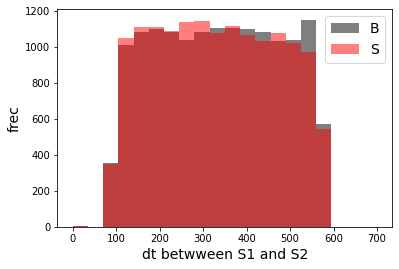

In [15]:
# to have the same number of background and signal events

B_pbot = B_pbot[:num_data]
B_ptop = B_ptop[:num_data]
B_ppeakS1 = B_ppeakS1[:num_data]
B_ppeakS2 = B_ppeakS2[:num_data]

print('B_pbot.shape: ', B_pbot.shape)
print('B_ptop.shape: ', B_ptop.shape)
print('B_ppeakS1.shape :', B_ppeakS1.shape)
print('B_ppeakS2.shape: ', B_ppeakS2.shape)


S_pbot = S_pbot[:num_data]
S_ptop = S_ptop[:num_data]
S_ppeakS1 = S_ppeakS1[:num_data]
S_ppeakS2 = S_ppeakS2[:num_data]

print('S_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)


# CONSTRUCT THE TIME DIFFERENCE BETWEEN PULSES

B_pdiffT = B_ppeakS2[:,0] - B_ppeakS1[:,0]
S_pdiffT = S_ppeakS2[:,0] - S_ppeakS1[:,0]

print('B_pdiffT.shape: ', B_pdiffT.shape)
print('S_pdiffT.shape: ', S_pdiffT.shape)


plt.hist(B_pdiffT, range=[0,700], bins=20, color='black', alpha=0.5, label='B')
plt.hist(S_pdiffT, range=[0,700], bins=20, color='red', alpha=0.5, label='S')
# plt.yscale('log')
# plt.xlim([0,100])
# plt.ylim([100,10000])
plt.xlabel('dt betwween S1 and S2',fontsize=14)
plt.ylabel('frec',fontsize=14)
plt.legend(fontsize=14)
plt.show()

##### Remove the absolute times of each pulse (we just need the time difference between pulses
other variables also can be removed if you want

In [16]:
remove_col = [0] # index = 0 is pT0

B_pbot = B_pbot
B_ptop = B_ptop
B_ppeakS1 = np.delete(B_ppeakS1, remove_col, axis=1)
B_ppeakS2 = np.delete(B_ppeakS2, remove_col, axis=1)

print('B_pbot.shape: ', B_pbot.shape)
print('B_ptop.shape: ', B_ptop.shape)
print('B_ppeakS1.shape :', B_ppeakS1.shape)
print('B_ppeakS2.shape: ', B_ppeakS2.shape)


S_pbot = S_pbot
S_ptop = S_ptop
S_ppeakS1 = np.delete(S_ppeakS1, remove_col, axis=1)
S_ppeakS2 = np.delete(S_ppeakS2, remove_col, axis=1)

print('S_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)

B_pbot.shape:  (15000,)
B_ptop.shape:  (15000,)
B_ppeakS1.shape : (15000, 7)
B_ppeakS2.shape:  (15000, 7)
S_pbot.shape:  (15000,)
S_ptop.shape:  (15000,)
S_ppeakS1.shape : (15000, 7)
S_ppeakS2.shape:  (15000, 7)


In [17]:
# concatenate the data

# all the background features
# X_mon_B = np.concatenate([B_ppeakS1, B_ppeakS2, np.reshape(B_pbot,(len(B_pbot),1)), np.reshape(B_ptop,(len(B_ptop),1)), np.reshape(B_pdiffT,(len(B_pdiffT),1)) ],axis=1)

# all the signal features
# X_mon_S = np.concatenate([S_ppeakS1, S_ppeakS2, np.reshape(S_pbot,(len(S_pbot),1)), np.reshape(S_ptop,(len(S_ptop),1)), np.reshape(S_pdiffT,(len(S_pdiffT),1)) ],axis=1)

X_mon_B = np.reshape(B_pdiffT,(len(B_pdiffT),1))
X_mon_S = np.reshape(S_pdiffT,(len(S_pdiffT),1))

print('X_mon_B.shape: ', X_mon_B.shape)
print('X_mon_S.shape: ', X_mon_S.shape)
print('')

del B_ppeakS1
del B_ppeakS2
del B_pbot
del B_ptop

del S_ppeakS1
del S_ppeakS2
del S_pbot
del S_ptop


X_mon5 = np.concatenate([X_mon_B, X_mon_S])

print('X_mon5.shape: ', X_mon5.shape)
del X_mon_B
del X_mon_S


# labels
y_mon5 = np.concatenate([np.zeros(num_data),np.ones(num_data)])




# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon5_aux, X_mon5_test, y_mon5_aux, y_mon5_test = train_test_split(X_mon5,
                                                                y_mon5,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon5,
                                                                shuffle=True)

del X_mon5
del y_mon5

X_mon5_train, X_mon5_val, y_mon5_train, y_mon5_val = train_test_split(X_mon5_aux,
                                                                  y_mon5_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon5_aux,
                                                                  shuffle=True)

del X_mon5_aux
del y_mon5_aux

print('')
print('X_mon5_train : ', X_mon5_train.shape)
print('y_mon5_train : ', y_mon5_train.shape)
print('X_mon5_val : ', X_mon5_val.shape)
print('y_mon5_val : ', y_mon5_val.shape)
print('X_mon5_test : ', X_mon5_test.shape)
print('y_mon5_test : ', y_mon5_test.shape)
print('')

X_mon_B.shape:  (15000, 1)
X_mon_S.shape:  (15000, 1)

X_mon5.shape:  (30000, 1)

X_mon5_train :  (15000, 1)
y_mon5_train :  (15000,)
X_mon5_val :  (5000, 1)
y_mon5_val :  (5000,)
X_mon5_test :  (10000, 1)
y_mon5_test :  (10000,)



##### Concatenate into one single big dataset (not the compressed features)

In [18]:
X_mon_train = np.concatenate([X_mon1_train,X_mon2_train,X_mon3_train,X_mon4_train,X_mon5_train],axis=1)
X_mon_test = np.concatenate([X_mon1_test,X_mon2_test,X_mon3_test,X_mon4_test,X_mon5_test],axis=1)
X_mon_val = np.concatenate([X_mon1_val,X_mon2_val,X_mon3_val,X_mon4_val,X_mon5_val],axis=1)

del X_mon1_train
del X_mon2_train
del X_mon3_train
del X_mon4_train
del X_mon5_train

del X_mon1_test
del X_mon2_test
del X_mon3_test
del X_mon4_test
del X_mon5_test

del X_mon1_val
del X_mon2_val
del X_mon3_val
del X_mon4_val
del X_mon5_val



y_mon_train = y_mon1_train
y_mon_test = y_mon1_test
y_mon_val = y_mon1_val

del y_mon1_train
del y_mon2_train
del y_mon3_train
del y_mon4_train
del y_mon5_train

del y_mon1_test
del y_mon2_test
del y_mon3_test
del y_mon4_test
del y_mon5_test

del y_mon1_val
del y_mon2_val
del y_mon3_val
del y_mon4_val
del y_mon5_val

In [19]:
print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')


X_mon_train :  (15000, 2744)
y_mon_train :  (15000,)
X_mon_val :  (5000, 2744)
y_mon_val :  (5000,)
X_mon_test :  (10000, 2744)
y_mon_test :  (10000,)



## CLASSIFIER

### 2 features

### 1st step: DNN for Automatic Feature Extraction

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2744)]            0         
_________________________________________________________________
dense (Dense)                (None, 32)                87840     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
_________________________________________________________________
dropout_2 (Dropout)          (None, 2)                 0     

Epoch 105/500
118/118 [==============================] - 0s 1ms/step - loss: 0.2802 - accuracy: 0.8958 - val_loss: 0.2427 - val_accuracy: 0.9176
Epoch 106/500
118/118 [==============================] - 0s 1ms/step - loss: 0.2565 - accuracy: 0.9061 - val_loss: 0.2159 - val_accuracy: 0.9278
Epoch 107/500
118/118 [==============================] - 0s 1ms/step - loss: 0.2336 - accuracy: 0.9199 - val_loss: 0.2197 - val_accuracy: 0.9300
Epoch 108/500
118/118 [==============================] - 0s 1ms/step - loss: 0.2498 - accuracy: 0.9125 - val_loss: 0.2180 - val_accuracy: 0.9294
Epoch 109/500
118/118 [==============================] - 0s 1ms/step - loss: 0.2428 - accuracy: 0.9182 - val_loss: 0.2156 - val_accuracy: 0.9306
Epoch 110/500
118/118 [==============================] - 0s 1ms/step - loss: 0.2359 - accuracy: 0.9178 - val_loss: 0.2209 - val_accuracy: 0.9318
Epoch 111/500
118/118 [==============================] - 0s 1ms/step - loss: 0.2446 - accuracy: 0.9227 - val_loss: 0.2151 - val_ac

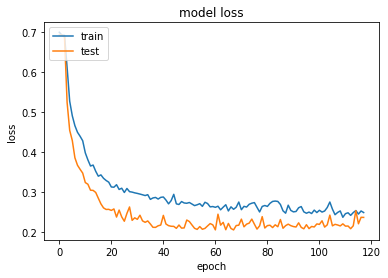

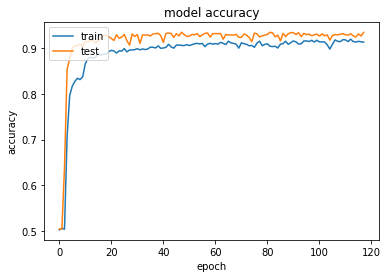

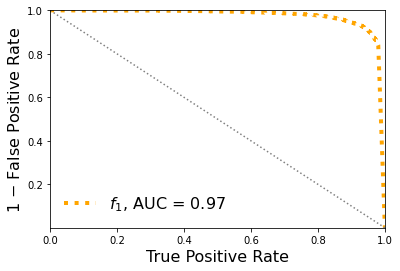

Classification score:


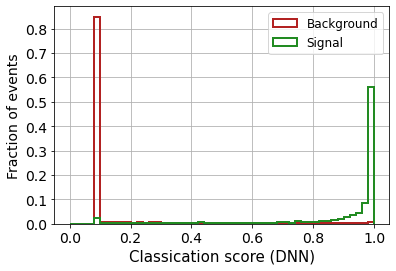


 ROC-AUC =  0.9735783436710083


In [20]:
# define the keras model

input_1d = Input(shape=(X_mon_train.shape[1],))

dense = Dense(32, activation='relu')(input_1d)
dense = Dropout(0.20)(dense)
dense = Dense(16, activation='relu')(dense)
dense = Dropout(0.20)(dense)
dense = Dense(2, activation='relu')(dense)
dense = Dropout(0.20)(dense)
output = Dense(1, activation='sigmoid')(dense)


# Create the model
model = keras.Model(inputs=[input_1d], outputs=output)

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [21]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9735783436710083


#### 2nd step: take the second to last layer

layer name you are selecting:  dense_2
shape:  (None, 2)

X_mon_train_int.shape:  (15000, 2)
X_mon_val_int.shape:  (5000, 2)
X_mon_test_int.shape:  (10000, 2)


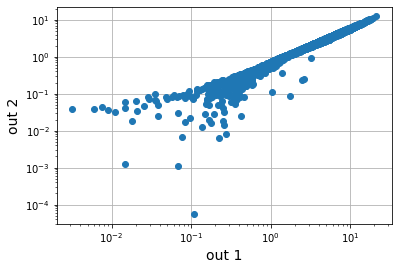

In [22]:
name_layer = (model.layers[-3]).name
print('layer name you are selecting: ', name_layer)
print('shape: ', (model.get_layer( name_layer ).output).shape )


# take the output of the second to last layer as AUTOMATIC FEATURE EXTRACTION
model_inter = Model(inputs=model.input,
                    outputs=model.get_layer( name_layer ).output)



X_mon_train_int = model_inter.predict(X_mon_train)
X_mon_val_int = model_inter.predict(X_mon_val)
X_mon_test_int = model_inter.predict(X_mon_test)

print('\nX_mon_train_int.shape: ', X_mon_train_int.shape)
print('X_mon_val_int.shape: ', X_mon_val_int.shape)
print('X_mon_test_int.shape: ', X_mon_test_int.shape)



plt.plot(X_mon_train_int[:,0], X_mon_train_int[:,1], 'o')
plt.xscale('log')
plt.yscale('log')
#plt.xlim([0.01,20])
plt.xlabel(r"out 1",fontsize=14)
plt.ylabel("out 2",fontsize=14)
plt.grid()
plt.show()

#### 3rd step: the output of the second to last layer is the input of an XGBoost

[0]	validation_0-logloss:0.61141	validation_1-logloss:0.61496
[1]	validation_0-logloss:0.54439	validation_1-logloss:0.55119
[2]	validation_0-logloss:0.48856	validation_1-logloss:0.49825
[3]	validation_0-logloss:0.44144	validation_1-logloss:0.45392
[4]	validation_0-logloss:0.40134	validation_1-logloss:0.41639
[5]	validation_0-logloss:0.36686	validation_1-logloss:0.38473
[6]	validation_0-logloss:0.33712	validation_1-logloss:0.35744
[7]	validation_0-logloss:0.31141	validation_1-logloss:0.33387
[8]	validation_0-logloss:0.28897	validation_1-logloss:0.31361
[9]	validation_0-logloss:0.26928	validation_1-logloss:0.29590
[10]	validation_0-logloss:0.25214	validation_1-logloss:0.28065
[11]	validation_0-logloss:0.23695	validation_1-logloss:0.26735
[12]	validation_0-logloss:0.22365	validation_1-logloss:0.25584
[13]	validation_0-logloss:0.21190	validation_1-logloss:0.24572
[14]	validation_0-logloss:0.20152	validation_1-logloss:0.23689
[15]	validation_0-logloss:0.19234	validation_1-logloss:0.22928
[1

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-logloss:0.17064	validation_1-logloss:0.21170
[19]	validation_0-logloss:0.16495	validation_1-logloss:0.20724
[20]	validation_0-logloss:0.15990	validation_1-logloss:0.20349
[21]	validation_0-logloss:0.15544	validation_1-logloss:0.20034
[22]	validation_0-logloss:0.15149	validation_1-logloss:0.19752
[23]	validation_0-logloss:0.14796	validation_1-logloss:0.19519
[24]	validation_0-logloss:0.14483	validation_1-logloss:0.19307
[25]	validation_0-logloss:0.14207	validation_1-logloss:0.19123
[26]	validation_0-logloss:0.13960	validation_1-logloss:0.18982
[27]	validation_0-logloss:0.13746	validation_1-logloss:0.18860
[28]	validation_0-logloss:0.13551	validation_1-logloss:0.18750
[29]	validation_0-logloss:0.13373	validation_1-logloss:0.18662
[30]	validation_0-logloss:0.13217	validation_1-logloss:0.18602
[31]	validation_0-logloss:0.13078	validation_1-logloss:0.18548
[32]	validation_0-logloss:0.12959	validation_1-logloss:0.18511
[33]	validation_0-logloss:0.12842	validation_1-logloss:

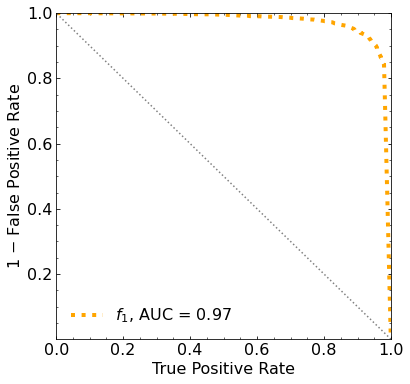

Classification score:


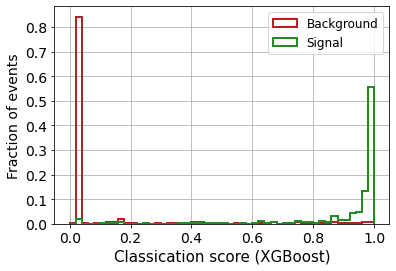


 ROC-AUC =  0.9723776820470083


In [23]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train_int,y_mon_train,eval_set=[(X_mon_train_int, y_mon_train), (X_mon_val_int, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test_int).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

In [24]:
print('\n ROC-AUC = ', roc_auc_xg)


 ROC-AUC =  0.9723776820470083


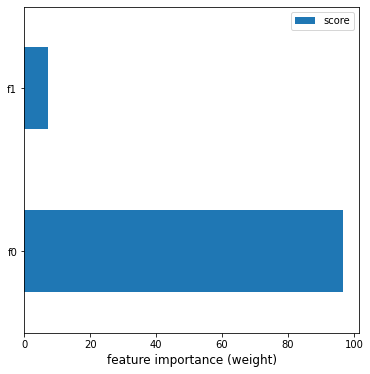

In [25]:
feature_important = classifier.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
#keys = ['pA_S1','pH_S1','pHT_S1','pL_S1','pL90_S1','pRMSW_S1','pHTL_S1','pA_S2','pH_S2','pHT_S2','pL_S2','pL90_S2','pRMSW_S2','pHTL_S2','pbot', 'ptop','pdiffT']
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh', figsize = (6,6)) ## plot top 10 features
plt.xlabel('feature importance (weight)', fontsize = 12)
plt.show()

### 3 features

### 1st step: DNN for Automatic Feature Extraction

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2744)]            0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                87840     
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 51        
_________________________________________________________________
dropout_5 (Dropout)          (None, 3)                 0   

Epoch 105/500
118/118 [==============================] - 0s 1ms/step - loss: 0.2075 - accuracy: 0.9194 - val_loss: 0.1882 - val_accuracy: 0.9342
Epoch 106/500
118/118 [==============================] - 0s 1ms/step - loss: 0.2021 - accuracy: 0.9218 - val_loss: 0.1876 - val_accuracy: 0.9334
Epoch 107/500
118/118 [==============================] - 0s 1ms/step - loss: 0.2024 - accuracy: 0.9228 - val_loss: 0.1935 - val_accuracy: 0.9344
Epoch 108/500
118/118 [==============================] - 0s 1ms/step - loss: 0.2105 - accuracy: 0.9268 - val_loss: 0.1975 - val_accuracy: 0.9312
Restoring model weights from the end of the best epoch.
Epoch 00108: early stopping


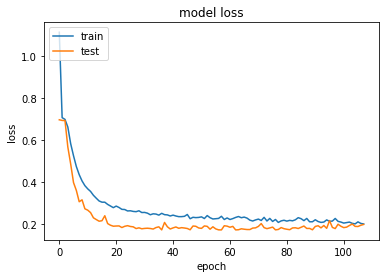

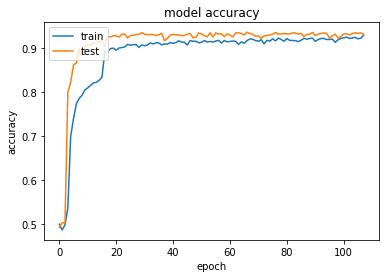

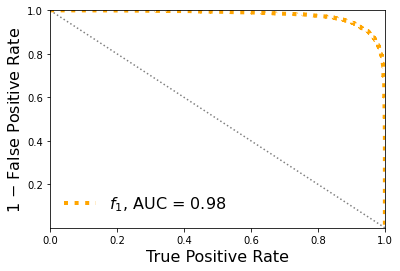

Classification score:


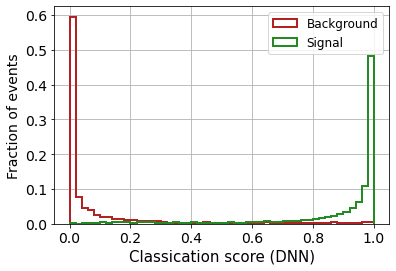


 ROC-AUC =  0.9790839496654996


In [26]:
# define the keras model

input_1d = Input(shape=(X_mon_train.shape[1],))

dense = Dense(32, activation='relu')(input_1d)
dense = Dropout(0.20)(dense)
dense = Dense(16, activation='relu')(dense)
dense = Dropout(0.20)(dense)
dense = Dense(3, activation='relu')(dense)
dense = Dropout(0.20)(dense)
output = Dense(1, activation='sigmoid')(dense)


# Create the model
model = keras.Model(inputs=[input_1d], outputs=output)

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [27]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9790839496654996


#### 2nd step: take the second to last layer

layer name you are selecting:  dense_6
shape:  (None, 3)

X_mon_train_int.shape:  (15000, 3)
X_mon_val_int.shape:  (5000, 3)
X_mon_test_int.shape:  (10000, 3)


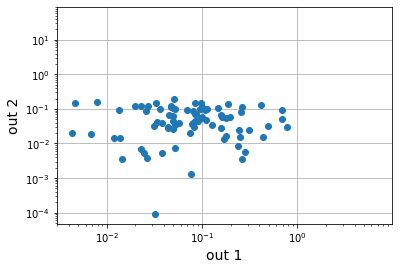

In [28]:
name_layer = (model.layers[-3]).name
print('layer name you are selecting: ', name_layer)
print('shape: ', (model.get_layer( name_layer ).output).shape )


# take the output of the second to last layer as AUTOMATIC FEATURE EXTRACTION
model_inter = Model(inputs=model.input,
                    outputs=model.get_layer( name_layer ).output)



X_mon_train_int = model_inter.predict(X_mon_train)
X_mon_val_int = model_inter.predict(X_mon_val)
X_mon_test_int = model_inter.predict(X_mon_test)

print('\nX_mon_train_int.shape: ', X_mon_train_int.shape)
print('X_mon_val_int.shape: ', X_mon_val_int.shape)
print('X_mon_test_int.shape: ', X_mon_test_int.shape)



plt.plot(X_mon_train_int[:,0], X_mon_train_int[:,1], 'o')
plt.xscale('log')
plt.yscale('log')
#plt.xlim([0.01,20])
plt.xlabel(r"out 1",fontsize=14)
plt.ylabel("out 2",fontsize=14)
plt.grid()
plt.show()

#### 3rd step: the output of the second to last layer is the input of an XGBoost

[0]	validation_0-logloss:0.61183	validation_1-logloss:0.61466
[1]	validation_0-logloss:0.54535	validation_1-logloss:0.55070
[2]	validation_0-logloss:0.48992	validation_1-logloss:0.49773
[3]	validation_0-logloss:0.44322	validation_1-logloss:0.45332
[4]	validation_0-logloss:0.40344	validation_1-logloss:0.41565
[5]	validation_0-logloss:0.36931	validation_1-logloss:0.38353
[6]	validation_0-logloss:0.33973	validation_1-logloss:0.35581
[7]	validation_0-logloss:0.31407	validation_1-logloss:0.33197
[8]	validation_0-logloss:0.29166	validation_1-logloss:0.31132
[9]	validation_0-logloss:0.27209	validation_1-logloss:0.29356
[10]	validation_0-logloss:0.25488	validation_1-logloss:0.27791
[11]	validation_0-logloss:0.23969	validation_1-logloss:0.26433
[12]	validation_0-logloss:0.22637	validation_1-logloss:0.25251
[13]	validation_0-logloss:0.21451	validation_1-logloss:0.24225
[14]	validation_0-logloss:0.20409	validation_1-logloss:0.23323
[15]	validation_0-logloss:0.19477	validation_1-logloss:0.22531
[1

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-logloss:0.17923	validation_1-logloss:0.21234
[18]	validation_0-logloss:0.17273	validation_1-logloss:0.20706
[19]	validation_0-logloss:0.16695	validation_1-logloss:0.20239
[20]	validation_0-logloss:0.16173	validation_1-logloss:0.19837
[21]	validation_0-logloss:0.15704	validation_1-logloss:0.19495
[22]	validation_0-logloss:0.15291	validation_1-logloss:0.19194
[23]	validation_0-logloss:0.14918	validation_1-logloss:0.18924
[24]	validation_0-logloss:0.14589	validation_1-logloss:0.18699
[25]	validation_0-logloss:0.14296	validation_1-logloss:0.18494
[26]	validation_0-logloss:0.14028	validation_1-logloss:0.18321
[27]	validation_0-logloss:0.13790	validation_1-logloss:0.18166
[28]	validation_0-logloss:0.13576	validation_1-logloss:0.18036
[29]	validation_0-logloss:0.13387	validation_1-logloss:0.17931
[30]	validation_0-logloss:0.13217	validation_1-logloss:0.17838
[31]	validation_0-logloss:0.13062	validation_1-logloss:0.17764
[32]	validation_0-logloss:0.12925	validation_1-logloss:

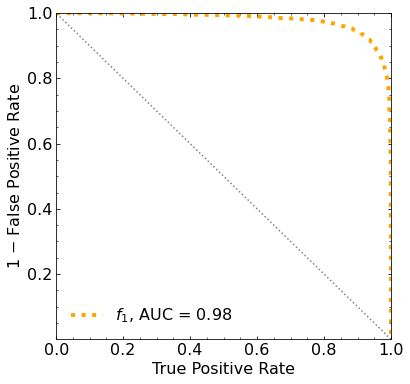

Classification score:


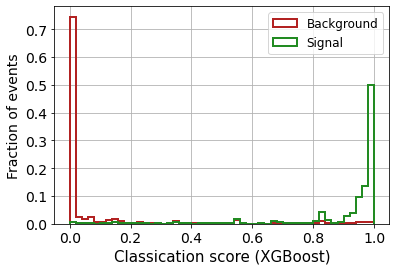


 ROC-AUC =  0.9782557795691827


In [29]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train_int,y_mon_train,eval_set=[(X_mon_train_int, y_mon_train), (X_mon_val_int, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test_int).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

In [30]:
print('\n ROC-AUC = ', roc_auc_xg)


 ROC-AUC =  0.9782557795691827


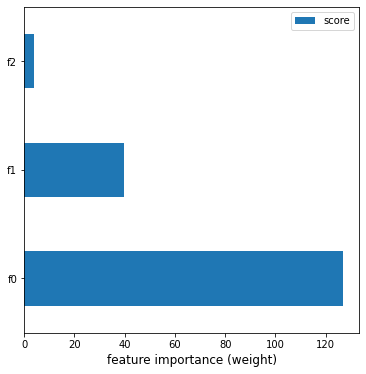

In [31]:
feature_important = classifier.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
#keys = ['pA_S1','pH_S1','pHT_S1','pL_S1','pL90_S1','pRMSW_S1','pHTL_S1','pA_S2','pH_S2','pHT_S2','pL_S2','pL90_S2','pRMSW_S2','pHTL_S2','pbot', 'ptop','pdiffT']
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh', figsize = (6,6)) ## plot top 10 features
plt.xlabel('feature importance (weight)', fontsize = 12)
plt.show()

### 4 features

### 1st step: DNN for Automatic Feature Extraction

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2744)]            0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                87840     
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 68        
_________________________________________________________________
dropout_8 (Dropout)          (None, 4)                 0   

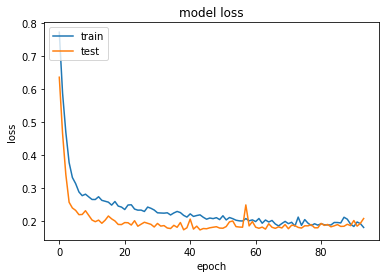

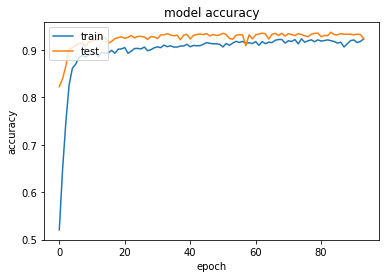

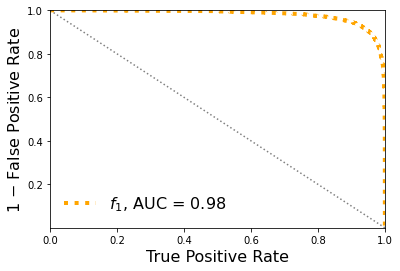

Classification score:


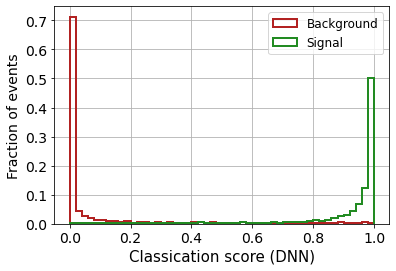


 ROC-AUC =  0.9798740765418386


In [32]:
# define the keras model

input_1d = Input(shape=(X_mon_train.shape[1],))

dense = Dense(32, activation='relu')(input_1d)
dense = Dropout(0.20)(dense)
dense = Dense(16, activation='relu')(dense)
dense = Dropout(0.20)(dense)
dense = Dense(4, activation='relu')(dense)
dense = Dropout(0.20)(dense)
output = Dense(1, activation='sigmoid')(dense)


# Create the model
model = keras.Model(inputs=[input_1d], outputs=output)

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [33]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9798740765418386


#### 2nd step: take the second to last layer

layer name you are selecting:  dense_10
shape:  (None, 4)

X_mon_train_int.shape:  (15000, 4)
X_mon_val_int.shape:  (5000, 4)
X_mon_test_int.shape:  (10000, 4)


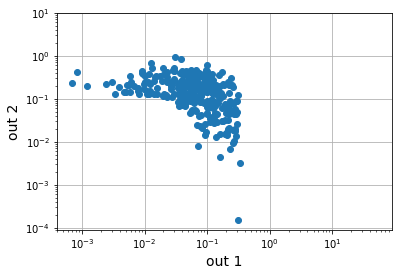

In [34]:
name_layer = (model.layers[-3]).name
print('layer name you are selecting: ', name_layer)
print('shape: ', (model.get_layer( name_layer ).output).shape )


# take the output of the second to last layer as AUTOMATIC FEATURE EXTRACTION
model_inter = Model(inputs=model.input,
                    outputs=model.get_layer( name_layer ).output)



X_mon_train_int = model_inter.predict(X_mon_train)
X_mon_val_int = model_inter.predict(X_mon_val)
X_mon_test_int = model_inter.predict(X_mon_test)

print('\nX_mon_train_int.shape: ', X_mon_train_int.shape)
print('X_mon_val_int.shape: ', X_mon_val_int.shape)
print('X_mon_test_int.shape: ', X_mon_test_int.shape)



plt.plot(X_mon_train_int[:,0], X_mon_train_int[:,1], 'o')
plt.xscale('log')
plt.yscale('log')
#plt.xlim([0.01,20])
plt.xlabel(r"out 1",fontsize=14)
plt.ylabel("out 2",fontsize=14)
plt.grid()
plt.show()

#### 3rd step: the output of the second to last layer is the input of an XGBoost

[0]	validation_0-logloss:0.61246	validation_1-logloss:0.61498
[1]	validation_0-logloss:0.54644	validation_1-logloss:0.55116
[2]	validation_0-logloss:0.49149	validation_1-logloss:0.49823
[3]	validation_0-logloss:0.44511	validation_1-logloss:0.45380
[4]	validation_0-logloss:0.40553	validation_1-logloss:0.41617
[5]	validation_0-logloss:0.37165	validation_1-logloss:0.38400
[6]	validation_0-logloss:0.34243	validation_1-logloss:0.35645
[7]	validation_0-logloss:0.31696	validation_1-logloss:0.33250
[8]	validation_0-logloss:0.29476	validation_1-logloss:0.31177
[9]	validation_0-logloss:0.27533	validation_1-logloss:0.29382
[10]	validation_0-logloss:0.25818	validation_1-logloss:0.27813
[11]	validation_0-logloss:0.24304	validation_1-logloss:0.26445
[12]	validation_0-logloss:0.22974	validation_1-logloss:0.25254


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-logloss:0.21797	validation_1-logloss:0.24211
[14]	validation_0-logloss:0.20756	validation_1-logloss:0.23286
[15]	validation_0-logloss:0.19835	validation_1-logloss:0.22492
[16]	validation_0-logloss:0.19018	validation_1-logloss:0.21779
[17]	validation_0-logloss:0.18289	validation_1-logloss:0.21167
[18]	validation_0-logloss:0.17644	validation_1-logloss:0.20624
[19]	validation_0-logloss:0.17065	validation_1-logloss:0.20151
[20]	validation_0-logloss:0.16550	validation_1-logloss:0.19736
[21]	validation_0-logloss:0.16092	validation_1-logloss:0.19361
[22]	validation_0-logloss:0.15682	validation_1-logloss:0.19042
[23]	validation_0-logloss:0.15312	validation_1-logloss:0.18766
[24]	validation_0-logloss:0.14986	validation_1-logloss:0.18530
[25]	validation_0-logloss:0.14698	validation_1-logloss:0.18325
[26]	validation_0-logloss:0.14438	validation_1-logloss:0.18142
[27]	validation_0-logloss:0.14204	validation_1-logloss:0.17983
[28]	validation_0-logloss:0.13989	validation_1-logloss:

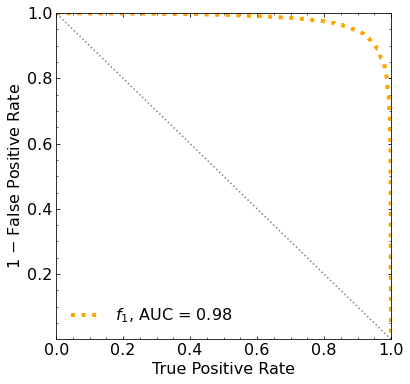

Classification score:


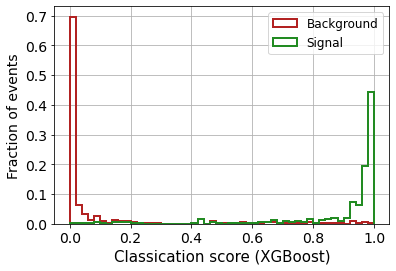


 ROC-AUC =  0.9788756120318025


In [35]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train_int,y_mon_train,eval_set=[(X_mon_train_int, y_mon_train), (X_mon_val_int, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test_int).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

In [36]:
print('\n ROC-AUC = ', roc_auc_xg)


 ROC-AUC =  0.9788756120318025


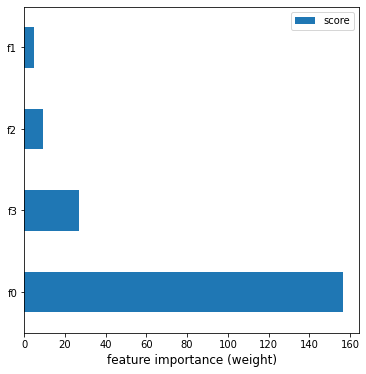

In [37]:
feature_important = classifier.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
#keys = ['pA_S1','pH_S1','pHT_S1','pL_S1','pL90_S1','pRMSW_S1','pHTL_S1','pA_S2','pH_S2','pHT_S2','pL_S2','pL90_S2','pRMSW_S2','pHTL_S2','pbot', 'ptop','pdiffT']
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh', figsize = (6,6)) ## plot top 10 features
plt.xlabel('feature importance (weight)', fontsize = 12)
plt.show()

### 5 features

### 1st step: DNN for Automatic Feature Extraction

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2744)]            0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                87840     
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_10 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 85        
_________________________________________________________________
dropout_11 (Dropout)         (None, 5)                 0   

Epoch 105/500
118/118 [==============================] - 0s 1ms/step - loss: 0.1806 - accuracy: 0.9288 - val_loss: 0.2074 - val_accuracy: 0.9296
Epoch 106/500
118/118 [==============================] - 0s 1ms/step - loss: 0.1793 - accuracy: 0.9264 - val_loss: 0.1893 - val_accuracy: 0.9322
Epoch 107/500
118/118 [==============================] - 0s 1ms/step - loss: 0.1845 - accuracy: 0.9261 - val_loss: 0.1898 - val_accuracy: 0.9364
Epoch 108/500
118/118 [==============================] - 0s 1ms/step - loss: 0.1809 - accuracy: 0.9259 - val_loss: 0.1933 - val_accuracy: 0.9334
Epoch 109/500
118/118 [==============================] - 0s 1ms/step - loss: 0.1606 - accuracy: 0.9385 - val_loss: 0.1995 - val_accuracy: 0.9352
Epoch 110/500
118/118 [==============================] - 0s 1ms/step - loss: 0.1599 - accuracy: 0.9400 - val_loss: 0.1967 - val_accuracy: 0.9262
Epoch 111/500
118/118 [==============================] - 0s 1ms/step - loss: 0.1694 - accuracy: 0.9352 - val_loss: 0.1931 - val_ac

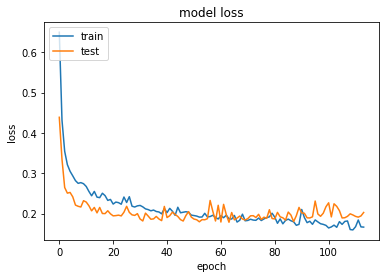

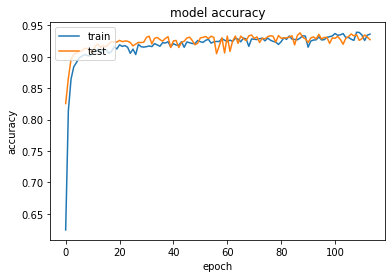

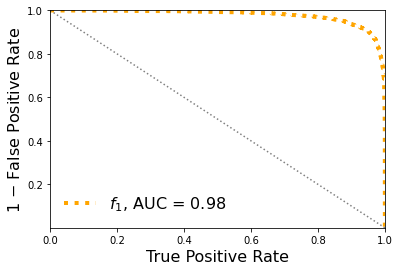

Classification score:


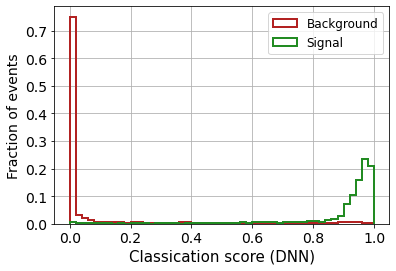


 ROC-AUC =  0.9771322044697863


In [38]:
# define the keras model

input_1d = Input(shape=(X_mon_train.shape[1],))

dense = Dense(32, activation='relu')(input_1d)
dense = Dropout(0.20)(dense)
dense = Dense(16, activation='relu')(dense)
dense = Dropout(0.20)(dense)
dense = Dense(5, activation='relu')(dense)
dense = Dropout(0.20)(dense)
output = Dense(1, activation='sigmoid')(dense)


# Create the model
model = keras.Model(inputs=[input_1d], outputs=output)

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [39]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9771322044697863


#### 2nd step: take the second to last layer

layer name you are selecting:  dense_14
shape:  (None, 5)

X_mon_train_int.shape:  (15000, 5)
X_mon_val_int.shape:  (5000, 5)
X_mon_test_int.shape:  (10000, 5)


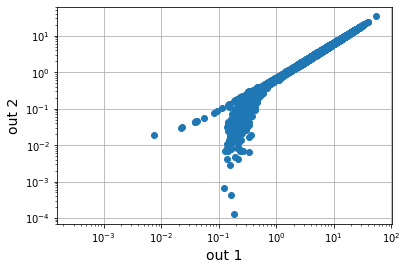

In [40]:
name_layer = (model.layers[-3]).name
print('layer name you are selecting: ', name_layer)
print('shape: ', (model.get_layer( name_layer ).output).shape )


# take the output of the second to last layer as AUTOMATIC FEATURE EXTRACTION
model_inter = Model(inputs=model.input,
                    outputs=model.get_layer( name_layer ).output)



X_mon_train_int = model_inter.predict(X_mon_train)
X_mon_val_int = model_inter.predict(X_mon_val)
X_mon_test_int = model_inter.predict(X_mon_test)

print('\nX_mon_train_int.shape: ', X_mon_train_int.shape)
print('X_mon_val_int.shape: ', X_mon_val_int.shape)
print('X_mon_test_int.shape: ', X_mon_test_int.shape)



plt.plot(X_mon_train_int[:,0], X_mon_train_int[:,1], 'o')
plt.xscale('log')
plt.yscale('log')
#plt.xlim([0.01,20])
plt.xlabel(r"out 1",fontsize=14)
plt.ylabel("out 2",fontsize=14)
plt.grid()
plt.show()

#### 3rd step: the output of the second to last layer is the input of an XGBoost

[0]	validation_0-logloss:0.61112	validation_1-logloss:0.61482
[1]	validation_0-logloss:0.54394	validation_1-logloss:0.55093
[2]	validation_0-logloss:0.48796	validation_1-logloss:0.49800
[3]	validation_0-logloss:0.44064	validation_1-logloss:0.45348
[4]	validation_0-logloss:0.40038	validation_1-logloss:0.41607
[5]	validation_0-logloss:0.36585	validation_1-logloss:0.38399
[6]	validation_0-logloss:0.33605	validation_1-logloss:0.35673
[7]	validation_0-logloss:0.31017	validation_1-logloss:0.33314
[8]	validation_0-logloss:0.28755	validation_1-logloss:0.31289
[9]	validation_0-logloss:0.26780	validation_1-logloss:0.29531
[10]	validation_0-logloss:0.25046	validation_1-logloss:0.28008
[11]	validation_0-logloss:0.23520	validation_1-logloss:0.26665
[12]	validation_0-logloss:0.22175	validation_1-logloss:0.25507
[13]	validation_0-logloss:0.20987	validation_1-logloss:0.24490
[14]	validation_0-logloss:0.19934	validation_1-logloss:0.23612
[15]	validation_0-logloss:0.19006	validation_1-logloss:0.22849
[1

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-logloss:0.16778	validation_1-logloss:0.21092
[19]	validation_0-logloss:0.16198	validation_1-logloss:0.20657
[20]	validation_0-logloss:0.15669	validation_1-logloss:0.20275
[21]	validation_0-logloss:0.15201	validation_1-logloss:0.19950
[22]	validation_0-logloss:0.14780	validation_1-logloss:0.19658
[23]	validation_0-logloss:0.14408	validation_1-logloss:0.19415
[24]	validation_0-logloss:0.14073	validation_1-logloss:0.19206
[25]	validation_0-logloss:0.13775	validation_1-logloss:0.19024
[26]	validation_0-logloss:0.13508	validation_1-logloss:0.18866
[27]	validation_0-logloss:0.13268	validation_1-logloss:0.18733
[28]	validation_0-logloss:0.13058	validation_1-logloss:0.18631
[29]	validation_0-logloss:0.12862	validation_1-logloss:0.18543
[30]	validation_0-logloss:0.12691	validation_1-logloss:0.18461
[31]	validation_0-logloss:0.12529	validation_1-logloss:0.18416
[32]	validation_0-logloss:0.12393	validation_1-logloss:0.18357
[33]	validation_0-logloss:0.12270	validation_1-logloss:

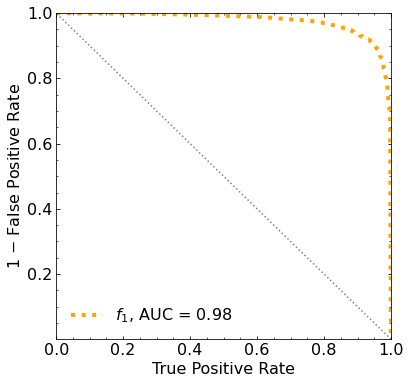

Classification score:


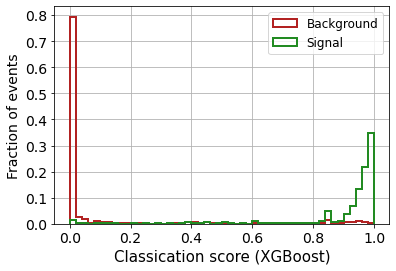


 ROC-AUC =  0.9758067722852062


In [41]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train_int,y_mon_train,eval_set=[(X_mon_train_int, y_mon_train), (X_mon_val_int, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test_int).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

In [42]:
print('\n ROC-AUC = ', roc_auc_xg)


 ROC-AUC =  0.9758067722852062


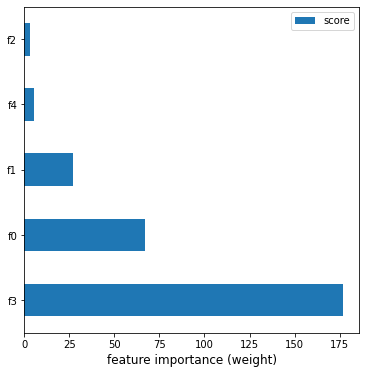

In [43]:
feature_important = classifier.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
#keys = ['pA_S1','pH_S1','pHT_S1','pL_S1','pL90_S1','pRMSW_S1','pHTL_S1','pA_S2','pH_S2','pHT_S2','pL_S2','pL90_S2','pRMSW_S2','pHTL_S2','pbot', 'ptop','pdiffT']
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh', figsize = (6,6)) ## plot top 10 features
plt.xlabel('feature importance (weight)', fontsize = 12)
plt.show()

### 6 features

### 1st step: DNN for Automatic Feature Extraction

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 2744)]            0         
_________________________________________________________________
dense_16 (Dense)             (None, 32)                87840     
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_13 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 6)                 102       
_________________________________________________________________
dropout_14 (Dropout)         (None, 6)                 0   

Epoch 105/500
118/118 [==============================] - 0s 1ms/step - loss: 0.1667 - accuracy: 0.9395 - val_loss: 0.1880 - val_accuracy: 0.9332
Epoch 106/500
118/118 [==============================] - 0s 1ms/step - loss: 0.1711 - accuracy: 0.9415 - val_loss: 0.1816 - val_accuracy: 0.9342
Epoch 107/500
118/118 [==============================] - 0s 1ms/step - loss: 0.1778 - accuracy: 0.9380 - val_loss: 0.1827 - val_accuracy: 0.9330
Restoring model weights from the end of the best epoch.
Epoch 00107: early stopping


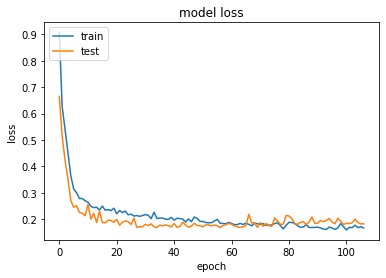

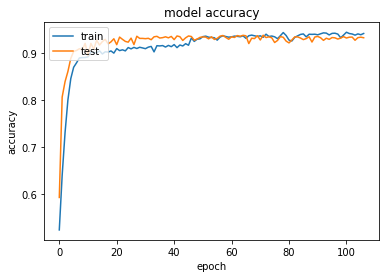

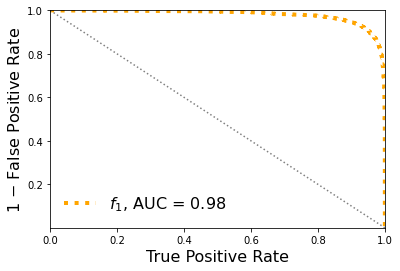

Classification score:


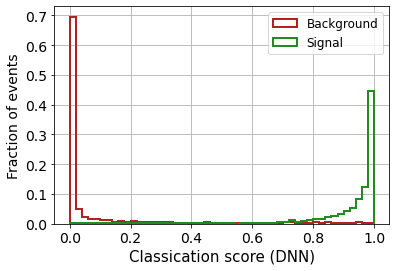


 ROC-AUC =  0.9791851182284068


In [44]:
# define the keras model

input_1d = Input(shape=(X_mon_train.shape[1],))

dense = Dense(32, activation='relu')(input_1d)
dense = Dropout(0.20)(dense)
dense = Dense(16, activation='relu')(dense)
dense = Dropout(0.20)(dense)
dense = Dense(6, activation='relu')(dense)
dense = Dropout(0.20)(dense)
output = Dense(1, activation='sigmoid')(dense)


# Create the model
model = keras.Model(inputs=[input_1d], outputs=output)

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [45]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9791851182284068


#### 2nd step: take the second to last layer

layer name you are selecting:  dense_18
shape:  (None, 6)

X_mon_train_int.shape:  (15000, 6)
X_mon_val_int.shape:  (5000, 6)
X_mon_test_int.shape:  (10000, 6)


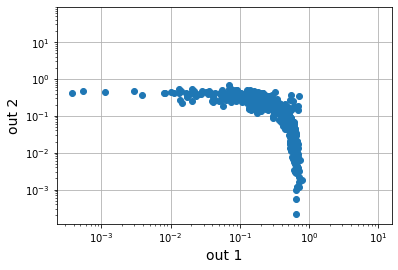

In [46]:
name_layer = (model.layers[-3]).name
print('layer name you are selecting: ', name_layer)
print('shape: ', (model.get_layer( name_layer ).output).shape )


# take the output of the second to last layer as AUTOMATIC FEATURE EXTRACTION
model_inter = Model(inputs=model.input,
                    outputs=model.get_layer( name_layer ).output)



X_mon_train_int = model_inter.predict(X_mon_train)
X_mon_val_int = model_inter.predict(X_mon_val)
X_mon_test_int = model_inter.predict(X_mon_test)

print('\nX_mon_train_int.shape: ', X_mon_train_int.shape)
print('X_mon_val_int.shape: ', X_mon_val_int.shape)
print('X_mon_test_int.shape: ', X_mon_test_int.shape)



plt.plot(X_mon_train_int[:,0], X_mon_train_int[:,1], 'o')
plt.xscale('log')
plt.yscale('log')
#plt.xlim([0.01,20])
plt.xlabel(r"out 1",fontsize=14)
plt.ylabel("out 2",fontsize=14)
plt.grid()
plt.show()

#### 3rd step: the output of the second to last layer is the input of an XGBoost

[0]	validation_0-logloss:0.61033	validation_1-logloss:0.61386
[1]	validation_0-logloss:0.54262	validation_1-logloss:0.54937
[2]	validation_0-logloss:0.48629	validation_1-logloss:0.49591
[3]	validation_0-logloss:0.43873	validation_1-logloss:0.45103
[4]	validation_0-logloss:0.39806	validation_1-logloss:0.41305
[5]	validation_0-logloss:0.36331	validation_1-logloss:0.38075
[6]	validation_0-logloss:0.33325	validation_1-logloss:0.35292
[7]	validation_0-logloss:0.30721	validation_1-logloss:0.32909
[8]	validation_0-logloss:0.28438	validation_1-logloss:0.30847
[9]	validation_0-logloss:0.26447	validation_1-logloss:0.29061
[10]	validation_0-logloss:0.24699	validation_1-logloss:0.27508
[11]	validation_0-logloss:0.23155	validation_1-logloss:0.26149
[12]	validation_0-logloss:0.21791	validation_1-logloss:0.24970
[13]	validation_0-logloss:0.20587	validation_1-logloss:0.23947
[14]	validation_0-logloss:0.19521	validation_1-logloss:0.23054
[15]	validation_0-logloss:0.18578	validation_1-logloss:0.22273
[1

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17]	validation_0-logloss:0.16988	validation_1-logloss:0.21000
[18]	validation_0-logloss:0.16315	validation_1-logloss:0.20488
[19]	validation_0-logloss:0.15719	validation_1-logloss:0.20043
[20]	validation_0-logloss:0.15193	validation_1-logloss:0.19653
[21]	validation_0-logloss:0.14716	validation_1-logloss:0.19310
[22]	validation_0-logloss:0.14297	validation_1-logloss:0.19006
[23]	validation_0-logloss:0.13915	validation_1-logloss:0.18745
[24]	validation_0-logloss:0.13567	validation_1-logloss:0.18517
[25]	validation_0-logloss:0.13256	validation_1-logloss:0.18326
[26]	validation_0-logloss:0.12982	validation_1-logloss:0.18178
[27]	validation_0-logloss:0.12737	validation_1-logloss:0.18043
[28]	validation_0-logloss:0.12517	validation_1-logloss:0.17916
[29]	validation_0-logloss:0.12316	validation_1-logloss:0.17829
[30]	validation_0-logloss:0.12137	validation_1-logloss:0.17746
[31]	validation_0-logloss:0.11978	validation_1-logloss:0.17689
[32]	validation_0-logloss:0.11828	validation_1-logloss:

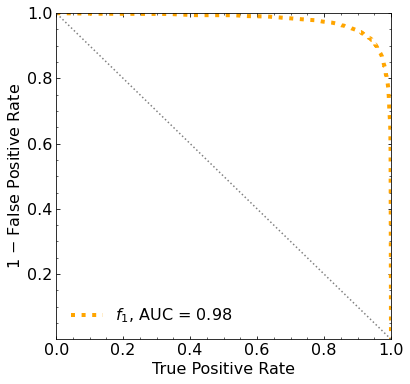

Classification score:


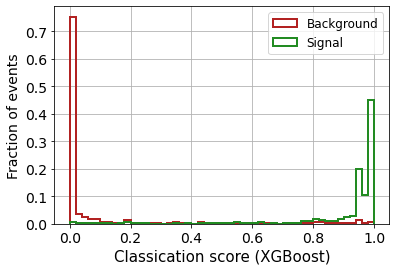


 ROC-AUC =  0.9784812586537324


In [47]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train_int,y_mon_train,eval_set=[(X_mon_train_int, y_mon_train), (X_mon_val_int, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test_int).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

In [48]:
print('\n ROC-AUC = ', roc_auc_xg)


 ROC-AUC =  0.9784812586537324


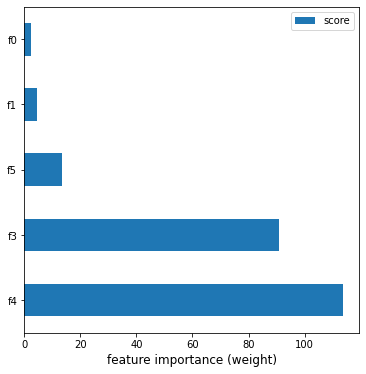

In [49]:
feature_important = classifier.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
#keys = ['pA_S1','pH_S1','pHT_S1','pL_S1','pL90_S1','pRMSW_S1','pHTL_S1','pA_S2','pH_S2','pHT_S2','pL_S2','pL90_S2','pRMSW_S2','pHTL_S2','pbot', 'ptop','pdiffT']
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh', figsize = (6,6)) ## plot top 10 features
plt.xlabel('feature importance (weight)', fontsize = 12)
plt.show()